##  Parte I: Análisis de la base de hogares y tipo de ocupación
 Ahora que ya están familiarizados con la Encuesta Permanente de Hogares
 (EPH) y la desocupación, vamos a complejizar un poco la construcción de las
 tasas del desempleo. Relacionaremos la información a nivel hogar

In [4]:
import os  
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt  
import statsmodels.api as sm     
import seaborn as sns

In [5]:
#Bases Tizi
#base_ind_04_sucia = pd.read_stata(r"C:\Users\tizip\OneDrive\Documentos\Tizi UdeSA\8- Ciencia de datos\Compu nueva\CC408-T1-4\TP3\Individual_t104.dta")
#base_ind_24_sucia = pd.read_excel(r"C:\Users\tizip\OneDrive\Documentos\Tizi UdeSA\8- Ciencia de datos\Compu nueva\CC408-T1-4\TP3\usu_individual_T124.xlsx")

#base_hog_04_sucia = pd.read_stata(r"C:\Users\tizip\OneDrive\Documentos\Tizi UdeSA\8- Ciencia de datos\Compu nueva\CC408-T1-4\TP4\Hogar_t104.dta")
#base_hog_24_sucia = pd.read_excel(r"C:\Users\tizip\OneDrive\Documentos\Tizi UdeSA\8- Ciencia de datos\Compu nueva\CC408-T1-4\TP4\usu_hogar_T124.xlsx")

In [6]:
#Bases Angie
base_ind_04_sucia = pd.read_stata(r'/Users/angelanavajas/Desktop/Ciencia de datos/CC408-T1-4/TP3/Individual_t104.dta')
base_ind_24_sucia = pd.read_excel(r'/Users/angelanavajas/Desktop/Ciencia de datos/CC408-T1-4/TP3/usu_individual_T124.xlsx')

base_hog_04_sucia = pd.read_stata(r'/Users/angelanavajas/Desktop/Ciencia de datos/CC408-T1-4/TP4/Hogar_t104.dta')
base_hog_24_sucia = pd.read_excel(r'/Users/angelanavajas/Desktop/Ciencia de datos/CC408-T1-4/TP4/usu_hogar_T124.xlsx')

### PUNTO 1
Exploren el diseño de registro de la base de hogar: a priori, ¿qué variables creen pueden ser predictivas de la desocupación y seria útil incluir para perfeccionar el ejercicio del TP3? Mencionen estas variables y justifiquen su elección.

### PUNTO 2
Descarguen la base de microdatos de la EPH correspondiente al primer trimestre de 2004 y 2024 en formato .dta y .xls, respectivamente. La base de hogares se llama Hogar_t104.dta y usu_hogar_T124.xls, respectivamente. Eliminen todas las observaciones que no corresponden a los aglomerados de Ciudad Autónoma de Buenos Aires o Gran Buenos Aires y unan ambos trimestres en una sola base. Esto es, a la base de la encuesta individual de cada año (que usaron en el TP3) unan la base de la encuesta de hogar. Asegúrese de estar usando las variables CODUSU y NRO_Hogar para el merge.


In [7]:
# LIMPIO BASE INDIVIDUAL

# me quedo solo con los valores de CABA y GBA
base_ind_04_filtrada = base_ind_04_sucia.loc[base_ind_04_sucia['aglomerado'].isin(['Ciudad de Buenos Aires', 'Partidos del GBA'])]
base_ind_24_filtrada = base_ind_24_sucia.loc[base_ind_24_sucia['AGLOMERADO'].isin([32, 33])]

#Para poder unir sin problema, me aseguro que als variables esten en el mismo formato

base_ind_04_filtrada.columns = base_ind_04_filtrada.columns.str.lower()
base_ind_24_filtrada.columns = base_ind_24_filtrada.columns.str.lower()

# concateno las bases
base_ind_prelimpieza = pd.concat([base_ind_24_filtrada, base_ind_04_filtrada])
print(base_ind_prelimpieza.columns.tolist())

['codusu', 'ano4', 'trimestre', 'nro_hogar', 'componente', 'h15', 'region', 'mas_500', 'aglomerado', 'pondera', 'ch03', 'ch04', 'ch05', 'ch06', 'ch07', 'ch08', 'ch09', 'ch10', 'ch11', 'ch12', 'ch13', 'ch14', 'ch15', 'ch15_cod', 'ch16', 'ch16_cod', 'nivel_ed', 'estado', 'cat_ocup', 'cat_inac', 'imputa', 'pp02c1', 'pp02c2', 'pp02c3', 'pp02c4', 'pp02c5', 'pp02c6', 'pp02c7', 'pp02c8', 'pp02e', 'pp02h', 'pp02i', 'pp03c', 'pp03d', 'pp3e_tot', 'pp3f_tot', 'pp03g', 'pp03h', 'pp03i', 'pp03j', 'intensi', 'pp04a', 'pp04b_cod', 'pp04b1', 'pp04b2', 'pp04b3_mes', 'pp04b3_ano', 'pp04b3_dia', 'pp04c', 'pp04c99', 'pp04d_cod', 'pp04g', 'pp05b2_mes', 'pp05b2_ano', 'pp05b2_dia', 'pp05c_1', 'pp05c_2', 'pp05c_3', 'pp05e', 'pp05f', 'pp05h', 'pp06a', 'pp06c', 'pp06d', 'pp06e', 'pp06h', 'pp07a', 'pp07c', 'pp07d', 'pp07e', 'pp07f1', 'pp07f2', 'pp07f3', 'pp07f4', 'pp07f5', 'pp07g1', 'pp07g2', 'pp07g3', 'pp07g4', 'pp07g_59', 'pp07h', 'pp07i', 'pp07j', 'pp07k', 'pp08d1', 'pp08d4', 'pp08f1', 'pp08f2', 'pp08j1', 'pp

In [8]:
# LIMPIO BASE HOGAR

# me quedo solo con los valores de CABA y GBA
base_hog_04_filtrada = base_hog_04_sucia.loc[base_hog_04_sucia['aglomerado'].isin(['Ciudad de Buenos Aires', 'Partidos del GBA'])]
base_hog_24_filtrada = base_hog_24_sucia.loc[base_hog_24_sucia['AGLOMERADO'].isin([32, 33])]

#Para poder unir sin problema, me aseguro que als variables esten en el mismo formato
base_hog_04_filtrada.columns = base_hog_04_filtrada.columns.str.lower()
base_hog_24_filtrada.columns = base_hog_24_filtrada.columns.str.lower()

# concateno las bases
base_hog_prelimpieza = pd.concat([base_hog_24_filtrada, base_hog_04_filtrada])
print(base_hog_prelimpieza.columns.tolist())

['codusu', 'ano4', 'trimestre', 'nro_hogar', 'realizada', 'region', 'mas_500', 'aglomerado', 'pondera', 'iv1', 'iv1_esp', 'iv2', 'iv3', 'iv3_esp', 'iv4', 'iv5', 'iv6', 'iv7', 'iv7_esp', 'iv8', 'iv9', 'iv10', 'iv11', 'iv12_1', 'iv12_2', 'iv12_3', 'ii1', 'ii2', 'ii3', 'ii3_1', 'ii4_1', 'ii4_2', 'ii4_3', 'ii5', 'ii5_1', 'ii6', 'ii6_1', 'ii7', 'ii7_esp', 'ii8', 'ii8_esp', 'ii9', 'v1', 'v2', 'v21', 'v22', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10', 'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19_a', 'v19_b', 'ix_tot', 'ix_men10', 'ix_mayeq10', 'itf', 'decifr', 'idecifr', 'rdecifr', 'gdecifr', 'pdecifr', 'adecifr', 'ipcf', 'deccfr', 'ideccfr', 'rdeccfr', 'gdeccfr', 'pdeccfr', 'adeccfr', 'pondih', 'vii1_1', 'vii1_2', 'vii2_1', 'vii2_2', 'vii2_3', 'vii2_4', 'idimph']


In [9]:
#Mergeo las dos bases

base_prelimpieza = pd.merge(base_ind_prelimpieza, base_hog_prelimpieza, on=["codusu", "nro_hogar"], how="inner")
print(base_prelimpieza.columns.tolist())

['codusu', 'ano4_x', 'trimestre_x', 'nro_hogar', 'componente', 'h15', 'region_x', 'mas_500_x', 'aglomerado_x', 'pondera_x', 'ch03', 'ch04', 'ch05', 'ch06', 'ch07', 'ch08', 'ch09', 'ch10', 'ch11', 'ch12', 'ch13', 'ch14', 'ch15', 'ch15_cod', 'ch16', 'ch16_cod', 'nivel_ed', 'estado', 'cat_ocup', 'cat_inac', 'imputa', 'pp02c1', 'pp02c2', 'pp02c3', 'pp02c4', 'pp02c5', 'pp02c6', 'pp02c7', 'pp02c8', 'pp02e', 'pp02h', 'pp02i', 'pp03c', 'pp03d', 'pp3e_tot', 'pp3f_tot', 'pp03g', 'pp03h', 'pp03i', 'pp03j', 'intensi', 'pp04a', 'pp04b_cod', 'pp04b1', 'pp04b2', 'pp04b3_mes', 'pp04b3_ano', 'pp04b3_dia', 'pp04c', 'pp04c99', 'pp04d_cod', 'pp04g', 'pp05b2_mes', 'pp05b2_ano', 'pp05b2_dia', 'pp05c_1', 'pp05c_2', 'pp05c_3', 'pp05e', 'pp05f', 'pp05h', 'pp06a', 'pp06c', 'pp06d', 'pp06e', 'pp06h', 'pp07a', 'pp07c', 'pp07d', 'pp07e', 'pp07f1', 'pp07f2', 'pp07f3', 'pp07f4', 'pp07f5', 'pp07g1', 'pp07g2', 'pp07g3', 'pp07g4', 'pp07g_59', 'pp07h', 'pp07i', 'pp07j', 'pp07k', 'pp08d1', 'pp08d4', 'pp08f1', 'pp08f2', '

In [10]:
# me fijo que las que aparecen en ambas bases no tengan valores diferentes 
variables_comunes = [
    'adeccfr', 'adecifr', 'aglomerado', 'ano4', 'codusu', 'deccfr', 
    'decifr', 'gdeccfr', 'gdecifr', 'ideccfr', 'idecifr', 'ipcf', 
    'itf', 'mas_500', 'nro_hogar', 'pdeccfr', 'pdecifr', 'pondera', 
    'pondih', 'rdeccfr', 'rdecifr', 'region', 'trimestre'
]

# Crear un diccionario para almacenar los resultados
diferencias_resumen = {}

# Analizar cada variable
for var in variables_comunes:
    columna_x = f"{var}_x"
    columna_y = f"{var}_y"
    
    # Comparar las columnas (asegúrate de que existen en la base)
    if columna_x in base_prelimpieza.columns and columna_y in base_prelimpieza.columns:
        # Identificar diferencias
        diferencias = base_prelimpieza[columna_x] != base_prelimpieza[columna_y]
        diferencias_count = diferencias.sum()
        
        # Almacenar resultados en el diccionario
        diferencias_resumen[var] = diferencias_count

# Convertir el resumen a un DataFrame para una mejor visualización
import pandas as pd
resumen_df = pd.DataFrame.from_dict(diferencias_resumen, orient="index", columns=["Diferencias"])
resumen_df.index.name = "Variable"
resumen_df.reset_index(inplace=True)

# Mostrar las diferencias
print(resumen_df)


      Variable  Diferencias
0      adeccfr            0
1      adecifr            0
2   aglomerado            0
3         ano4            0
4       deccfr            0
5       decifr            0
6      gdeccfr            0
7      gdecifr            0
8      ideccfr         7051
9      idecifr         7051
10        ipcf          334
11         itf            0
12     mas_500            0
13     pdeccfr         7051
14     pdecifr         7051
15     pondera            0
16      pondih         7647
17     rdeccfr            0
18     rdecifr            0
19      region            0
20   trimestre            0


In [11]:
# Mergeo las dos bases bien, fijandome que no duplique las variables 
base_prelimpieza = pd.merge(base_ind_prelimpieza, base_hog_prelimpieza, 
                          on=["codusu", "nro_hogar"], 
                          suffixes=('', '_dup'))

# Eliminar columnas duplicadas con sufijo '_dup'
for col in base_prelimpieza.columns:
    if col.endswith('_dup') and base_prelimpieza[col[:-4]].equals(base_prelimpieza[col]):
        base_prelimpieza.drop(columns=col, inplace=True)

print(base_prelimpieza.columns.tolist())

['codusu', 'ano4', 'trimestre', 'nro_hogar', 'componente', 'h15', 'region', 'mas_500', 'aglomerado', 'pondera', 'ch03', 'ch04', 'ch05', 'ch06', 'ch07', 'ch08', 'ch09', 'ch10', 'ch11', 'ch12', 'ch13', 'ch14', 'ch15', 'ch15_cod', 'ch16', 'ch16_cod', 'nivel_ed', 'estado', 'cat_ocup', 'cat_inac', 'imputa', 'pp02c1', 'pp02c2', 'pp02c3', 'pp02c4', 'pp02c5', 'pp02c6', 'pp02c7', 'pp02c8', 'pp02e', 'pp02h', 'pp02i', 'pp03c', 'pp03d', 'pp3e_tot', 'pp3f_tot', 'pp03g', 'pp03h', 'pp03i', 'pp03j', 'intensi', 'pp04a', 'pp04b_cod', 'pp04b1', 'pp04b2', 'pp04b3_mes', 'pp04b3_ano', 'pp04b3_dia', 'pp04c', 'pp04c99', 'pp04d_cod', 'pp04g', 'pp05b2_mes', 'pp05b2_ano', 'pp05b2_dia', 'pp05c_1', 'pp05c_2', 'pp05c_3', 'pp05e', 'pp05f', 'pp05h', 'pp06a', 'pp06c', 'pp06d', 'pp06e', 'pp06h', 'pp07a', 'pp07c', 'pp07d', 'pp07e', 'pp07f1', 'pp07f2', 'pp07f3', 'pp07f4', 'pp07f5', 'pp07g1', 'pp07g2', 'pp07g3', 'pp07g4', 'pp07g_59', 'pp07h', 'pp07i', 'pp07j', 'pp07k', 'pp08d1', 'pp08d4', 'pp08f1', 'pp08f2', 'pp08j1', 'pp

In [12]:
base_prelimpieza.shape

(14698, 248)

### PUNTO 3
Limpien la base de datos tomando criterios que hagan sentido. Explicar cualquier decisión como el tratamiento de valores faltantes (missing values), extremos (outliers), o variables categóricas. Justifique sus decisiones.

In [13]:
# TRATAMIENTO CATEGORICAS

# como hay datos que tienen distintas etiquetas en las dos bases que concatenamos, tenemos que  renombrar las etiquetas de una de las bases asi se pueden tener todos los datos con el mismo valor
variables_interes = base_prelimpieza[["ch04", "ch06", "ch07", "ch08", "nivel_ed", "estado", "cat_inac", "componente", "h15", "mas_500", "aglomerado", "ch03", "v5", "v6", "v7", "v8", "v11", "v12", "v13", "v17", "v19_a", "v19_b", "pp02h"]]

for i in variables_interes:
    if i == "ch04": 
        base_prelimpieza['ch04'] = base_prelimpieza['ch04'].replace({
            'Mujer': 2,
            'Varón': 1})
    elif i == "ch06":
        base_prelimpieza['ch06'] = base_prelimpieza['ch06'].replace({
            '98 y más años' : 98, 
            'Menos de 1 año' : 0})
        # cambio el formato de los valores de esta columna porque la mitad estaba en float y la mitas en int
        base_prelimpieza['ch06'] = base_prelimpieza['ch06'].astype(int)
    elif i == "ch07":
        base_prelimpieza['ch07'] = base_prelimpieza['ch07'].replace({
            'Unido': 1, 
            'Casado': 2, 
            'Separado o divorciado': 3, 
            'Viudo': 4, 
            'Soltero': 5})
    elif i == "ch08":
        base_prelimpieza['ch08'] = base_prelimpieza['ch08'].replace({
            'Obra social (incluye PAMI)': 1,  
            'Mutual/Prepaga/Servicio de emergencia': 2,  
            'Planes y seguros públicos': 3,  
            'No paga ni le descuentan': 4,  
            'Ns./Nr.': 9,  
            'Obra social y mutual/prepaga/servicio de emergencia': 12,  
            'Obra social y planes y seguros públicos': 13,  
            'Mutual/prepaga/servicio de emergencia/planes y seguros públi': 23,
            'Obra Social, mutual/prepaga/servicio de emergencia y planes y seguros públicos': 123})
    elif i == "nivel_ed":
        base_prelimpieza['nivel_ed'] = base_prelimpieza['nivel_ed'].replace({
            'Primaria Incompleta (incluye educación especial)': 1,  
            'Primaria Completa': 2,  
            'Secundaria Incompleta': 3,  
            'Secundaria Completa': 4,  
            'Superior Universitaria Incompleta': 5,  
            'Superior Universitaria Completa': 6, 
            'Sin instrucción': 7,  
            'Ns./Nr.': 9})
    elif i == "estado":
        base_prelimpieza['estado'] = base_prelimpieza['estado'].replace({
            'Ocupado': 1,  
            'Desocupado': 2,  
            'Inactivo': 3,  
            'Menor de 10 años': 4,  
            'Entrevista individual no realizada (no respuesta al cuestion': 0})
    elif i == "cat_inac":
        base_prelimpieza['cat_inac'] = base_prelimpieza['cat_inac'].replace({
            0.0 : 0,
            'Jubilado/pensionado': 1,  
            'Rentista': 2,  
            'Estudiante': 3,  
            'Ama de casa': 4,  
            'Menor de 6 años': 5,  
            'Discapacitado': 6,  
            'Otros': 7})
    elif i == "componente":
        base_prelimpieza['componente'] = base_prelimpieza['componente'].replace({
            'Servicio doméstico en hogares': 51})
        base_prelimpieza['componente'] = base_prelimpieza['componente'].astype(int)
    elif i == "h15":
        base_prelimpieza['h15'] = base_prelimpieza['h15'].replace({
            "Sí": 1,
            "No": 0,
            2 : 0})
        base_prelimpieza['h15'] = base_prelimpieza['h15'].astype(int)
    elif i == "mas_500":
        base_prelimpieza['mas_500'] = base_prelimpieza['mas_500'].replace({
            'N' : 1,
            'S' : 0})
    elif i == "aglomerado":
        base_prelimpieza['aglomerado'] = base_prelimpieza['aglomerado'].replace({
            'Ciudad de Buenos Aires' : 32,
            'Partidos del GBA' : 33})
    elif i == "ch03":
        base_prelimpieza['ch03'] = base_prelimpieza['ch03'].replace({
            'Jefe' : 1,
            'Cónyuge/Pareja' : 2,
            'Hijo/Hijastro' : 3,
            'Yerno/Nuera' : 4,
            'Nieto' : 5,
            'Madre/Padre' : 6,
            'Suegro' : 7,
            'Hermano' : 8,
            'Otros familiares' : 9,
            'No familiares' : 10})
    elif i == "v5":
        base_prelimpieza['v5'] = base_prelimpieza['v5'].replace({
            "Sí": 1,
            "No": 2,
            "Ns./Nr.":9})
    elif i == "v6":
        base_prelimpieza['v6'] = base_prelimpieza['v6'].replace({
            "Sí": 1,
            "No": 2,
            "Ns./Nr.":9})    
        base_prelimpieza['v6'] = base_prelimpieza['v6'].astype(int)
    elif i == "v7":
        base_prelimpieza['v7'] = base_prelimpieza['v7'].replace({
            "Sí": 1,
            "No": 2,
            "Ns./Nr.":9})
    elif i == "v8":
        base_prelimpieza['v8'] = base_prelimpieza['v8'].replace({
            "Sí": 1,
            "No": 2,
            "Ns./Nr.":9})
    elif i == "v11":
        base_prelimpieza['v11'] = base_prelimpieza['v11'].replace({
            "Sí": 1,
            "No": 2,
            "Ns./Nr.":9})
    elif i == "v12":
        base_prelimpieza['v12'] = base_prelimpieza['v12'].replace({
            "Sí": 1,
            "No": 2,
            "Ns./Nr.":9})
    elif i == "v13":
        base_prelimpieza['v13'] = base_prelimpieza['v13'].replace({
            "Sí": 1,
            "No": 2,
            "Ns./Nr.":9})
    elif i == "v17":
        base_prelimpieza['v17'] = base_prelimpieza['v17'].replace({
            "Sí": 1,
            "No": 2,
            "Ns./Nr.":9})    
    elif i == "v19_a":
        base_prelimpieza['v19_a'] = base_prelimpieza['v19_a'].replace({
            "Sí": 1,
            "No": 2,
            "Ns./Nr.":9})
    elif i == "v19_b":
        base_prelimpieza['v19_b'] = base_prelimpieza['v19_b'].replace({
            "Sí": 1,
            "No": 2,
            "Ns./Nr.":9})
    elif i == "pp02h":
        base_prelimpieza['pp02h'] = base_prelimpieza['pp02h'].replace({
            "Sí": 1,
            "No": 2,
            "Ns./Nr.":9})
        base_prelimpieza['pp02h'] = base_prelimpieza['pp02h'].astype(int)

    conteo = base_prelimpieza.groupby(i).size()
    print("\n", "La cantidad de datos en la variable", i, "por valor de etiqueta", "\n", conteo)


 La cantidad de datos en la variable ch04 por valor de etiqueta 
 ch04
1    6973
2    7725
dtype: int64

 La cantidad de datos en la variable ch06 por valor de etiqueta 
 ch06
-1      51
 0     131
 1     180
 2     198
 3     191
      ... 
 94      4
 95      2
 96      4
 97      1
 98      4
Length: 100, dtype: int64

 La cantidad de datos en la variable ch07 por valor de etiqueta 
 ch07
1    2118
2    3879
3     797
4     829
5    7062
9      13
dtype: int64

 La cantidad de datos en la variable ch08 por valor de etiqueta 
 ch08
1     7876
2     1176
3       49
4     5321
9       36
12     232
13       3
23       5
dtype: int64

 La cantidad de datos en la variable nivel_ed por valor de etiqueta 
 nivel_ed
1    2273
2    2374
3    2790
4    2696
5    1583
6    1755
7    1227
dtype: int64

 La cantidad de datos en la variable estado por valor de etiqueta 
 estado
0      51
1    6303
2     839
3    5462
4    2043
dtype: int64

 La cantidad de datos en la variable cat_inac por valor

/var/folders/9r/73xgxgj17t7btpfss2pdczcr0000gn/T/ipykernel_39521/795321814.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_prelimpieza['ch04'] = base_prelimpieza['ch04'].replace({
/var/folders/9r/73xgxgj17t7btpfss2pdczcr0000gn/T/ipykernel_39521/795321814.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_prelimpieza['ch06'] = base_prelimpieza['ch06'].replace({
/var/folders/9r/73xgxgj17t7btpfss2pdczcr0000gn/T/ipykernel_39521/795321814.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be 

In [14]:
# VALORES NEGATIVOS EN EDAD

valores_negativos_edad = base_prelimpieza['ch06'] < 0
# Cantidad de datos negativos
cantidad_negativos_edad = valores_negativos_edad.sum()
print("Cantidad de valores negativos en variable edad:", cantidad_negativos_edad)

# Me quedo con los valores mayores o iguales a 0 de edad
base_prelimpieza = base_prelimpieza[base_prelimpieza['ch06'] >= 0]
valores_negativos_edad_post = base_prelimpieza['ch06'] < 0
cantidad_negativos_edad_post = valores_negativos_edad_post.sum()
print("Cantidad de valores negativos en variable edad post limpieza :", cantidad_negativos_edad_post)

Cantidad de valores negativos en variable edad: 51
Cantidad de valores negativos en variable edad post limpieza : 0


In [15]:
base_prelimpieza.shape

(14647, 248)

In [16]:
# VALORES NEGATIVOS EN INGRESO POR CIRCULO FAMILIAR

valores_negativos_ipcf = base_prelimpieza[base_prelimpieza['ipcf'] < 0]
# Cantidad de datos negativos
cantidad_negativos_ipcf = len(valores_negativos_ipcf)

# Mostrar resultados
print("Cantidad de valores negativos en variable ipcf:", cantidad_negativos_ipcf)

Cantidad de valores negativos en variable ipcf: 0


In [17]:
#  MISSING VALUES

missing_values = variables_interes.isnull().sum()

# Mostrar las columnas con el número de valores faltantes
print(missing_values)

# Mostrar solo las columnas con valores faltantes
missing_values_with_data = missing_values[missing_values > 0]
print("\nColumnas con valores faltantes:")
print(missing_values_with_data)

# En las variables de hogar habia la misma cantidad en todas que ponian no sabe no responde, por lo que quiero confirmar que son las mismas personas asi solo clasifico esos valores como missing values
columnas = ['v5', 'v6', 'v7', 'v8', 'v11', 'v12', 'v13', 'v17', 'v19_a', 'v19_b']
# Filtramos las filas donde las columnas seleccionadas tienen el valor "9"
mask = (base_prelimpieza[columnas] == 9).all(axis=1)
# Obtenemos solo las filas de las columnas que nos interesan
filas_ns_nr = base_prelimpieza.loc[mask, columnas]
# Mostrar las filas donde todas las columnas tienen el valor "9"
print("ni idea", filas_ns_nr)

# Como vi que si son, reemplazo los valores "9" por NaN en las columnas seleccionadas
base_prelimpieza[columnas] = base_prelimpieza[columnas].replace(9, pd.NA)
# Contar cuántos NaN hay en las columnas seleccionadas
missing_count = base_prelimpieza[columnas].isna().sum()
# Mostrar el conteo de valores faltantes (NaN)
print("la cantidad de NA es: ", missing_count)

# Eliminar filas con NaN en las columnas seleccionadas
base_limpia = base_prelimpieza.dropna(subset = columnas)

# Ver el DataFrame resultante
base_limpia.shape

ch04          0
ch06          0
ch07          0
ch08          0
nivel_ed      0
estado        0
cat_inac      0
componente    0
h15           0
mas_500       0
aglomerado    0
ch03          0
v5            0
v6            0
v7            0
v8            0
v11           0
v12           0
v13           0
v17           0
v19_a         0
v19_b         0
pp02h         0
dtype: int64

Columnas con valores faltantes:
Series([], dtype: int64)
ni idea       v5  v6  v7  v8  v11  v12  v13  v17  v19_a  v19_b
13     9   9   9   9    9    9    9    9      9      9
14     9   9   9   9    9    9    9    9      9      9
15     9   9   9   9    9    9    9    9      9      9
16     9   9   9   9    9    9    9    9      9      9
24     9   9   9   9    9    9    9    9      9      9
25     9   9   9   9    9    9    9    9      9      9
26     9   9   9   9    9    9    9    9      9      9
2170   9   9   9   9    9    9    9    9      9      9
2171   9   9   9   9    9    9    9    9      9      9
217

(14614, 248)

In [55]:
base_limpia = base_limpia[base_limpia['v6'] != 0]


In [ ]:
#fijarme en que año estan los 0 
#Saco los 0 de la v6 

In [56]:
# Función para transformar variables en dummies
def transformar_a_dummies(dataframe, columnas):
    """
    Transforma variables categóricas con valores 1 y 2 en dummies (1 para 1, 0 para 2) 
    directamente en el DataFrame original, y muestra un resumen antes y después de la transformación.
    
    Parámetros:
    - dataframe: DataFrame de pandas.
    - columnas: Lista de nombres de columnas a transformar.
    
    Retorna:
    - None (modifica el DataFrame en su lugar).
    """
    print("Resumen antes de la transformación:")
    print(dataframe[columnas].head())  # Mostrar solo las columnas seleccionadas

    for columna in columnas:
        dataframe[columna] = dataframe[columna].apply(lambda x: 1 if x == 1 else (0 if x == 2 else x))
    
    print("\nResumen después de la transformación:")
    print(dataframe[columnas].head())  # Mostrar nuevamente solo las columnas seleccionadas para verificar el cambio

# Lista de columnas a transformar
columnas_sino = ["v5","v6", "v7", "v8", "v11", "v12", "v13", "v17", "v19_a", "v19_b"]

# Aplicar la función directamente a base_limpia
transformar_a_dummies(base_limpia, columnas_sino)



Resumen antes de la transformación:
  v5 v6 v7 v8 v11 v12 v13 v17 v19_a v19_b
0  2  2  2  2   2   2   2   2     2     2
1  2  2  2  2   2   2   2   2     2     2
2  2  2  2  2   2   2   2   2     2     2
3  2  2  2  2   2   2   2   2     2     2
4  2  2  2  2   2   2   2   2     2     2

Resumen después de la transformación:
  v5  v6 v7 v8 v11 v12 v13 v17 v19_a v19_b
0  0   0  0  0   0   0   0   0     0     0
1  0   0  0  0   0   0   0   0     0     0
2  0   0  0  0   0   0   0   0     0     0
3  0   0  0  0   0   0   0   0     0     0
4  0   0  0  0   0   0   0   0     0     0


/var/folders/9r/73xgxgj17t7btpfss2pdczcr0000gn/T/ipykernel_39521/1312696236.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[columna] = dataframe[columna].apply(lambda x: 1 if x == 1 else (0 if x == 2 else x))


In [57]:
# CATEGORICAS A DUMMIES

base_limpia[["ch04", "ch07", "ch08", "nivel_ed", "estado", "cat_inac", "componente", "h15", "mas_500", "aglomerado", "ch03", "v5", "v6", "v7", "v8", "v11", "v12", "v13", "v17", "v19_a", "v19_b"]] = base_prelimpieza[["ch04", "ch07", "ch08", "nivel_ed", "estado", "cat_inac", "componente", "h15", "mas_500", "aglomerado", "ch03", "v5", "v6", "v7", "v8", "v11", "v12", "v13", "v17", "v19_a", "v19_b"]].astype('category')
base_limpia_dummies = pd.get_dummies(base_limpia, columns=["ch04", "ch07", "ch08", "nivel_ed", "estado", "cat_inac", "componente", "h15", "mas_500", "aglomerado", "ch03", "v6"])

print(base_limpia_dummies.columns.tolist())

['codusu', 'ano4', 'trimestre', 'nro_hogar', 'region', 'pondera', 'ch05', 'ch06', 'ch09', 'ch10', 'ch11', 'ch12', 'ch13', 'ch14', 'ch15', 'ch15_cod', 'ch16', 'ch16_cod', 'cat_ocup', 'imputa', 'pp02c1', 'pp02c2', 'pp02c3', 'pp02c4', 'pp02c5', 'pp02c6', 'pp02c7', 'pp02c8', 'pp02e', 'pp02h', 'pp02i', 'pp03c', 'pp03d', 'pp3e_tot', 'pp3f_tot', 'pp03g', 'pp03h', 'pp03i', 'pp03j', 'intensi', 'pp04a', 'pp04b_cod', 'pp04b1', 'pp04b2', 'pp04b3_mes', 'pp04b3_ano', 'pp04b3_dia', 'pp04c', 'pp04c99', 'pp04d_cod', 'pp04g', 'pp05b2_mes', 'pp05b2_ano', 'pp05b2_dia', 'pp05c_1', 'pp05c_2', 'pp05c_3', 'pp05e', 'pp05f', 'pp05h', 'pp06a', 'pp06c', 'pp06d', 'pp06e', 'pp06h', 'pp07a', 'pp07c', 'pp07d', 'pp07e', 'pp07f1', 'pp07f2', 'pp07f3', 'pp07f4', 'pp07f5', 'pp07g1', 'pp07g2', 'pp07g3', 'pp07g4', 'pp07g_59', 'pp07h', 'pp07i', 'pp07j', 'pp07k', 'pp08d1', 'pp08d4', 'pp08f1', 'pp08f2', 'pp08j1', 'pp08j2', 'pp08j3', 'pp09a', 'pp09a_esp', 'pp09b', 'pp09c', 'pp09c_esp', 'pp10a', 'pp10c', 'pp10d', 'pp10e', 'pp11a

/var/folders/9r/73xgxgj17t7btpfss2pdczcr0000gn/T/ipykernel_39521/1261365808.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_limpia[["ch04", "ch07", "ch08", "nivel_ed", "estado", "cat_inac", "componente", "h15", "mas_500", "aglomerado", "ch03", "v5", "v6", "v7", "v8", "v11", "v12", "v13", "v17", "v19_a", "v19_b"]] = base_prelimpieza[["ch04", "ch07", "ch08", "nivel_ed", "estado", "cat_inac", "componente", "h15", "mas_500", "aglomerado", "ch03", "v5", "v6", "v7", "v8", "v11", "v12", "v13", "v17", "v19_a", "v19_b"]].astype('category')


In [58]:
base_limpia_dummies.shape

(14607, 306)

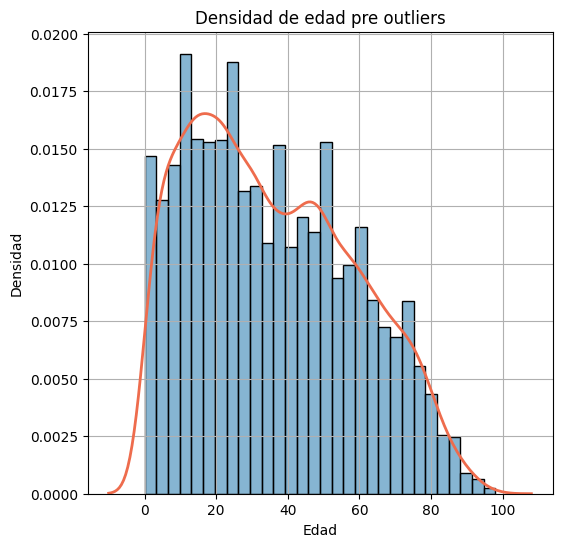

In [20]:
# OUTLIERS DE EDAD

### DENSIDAD DE EDAD --> VER OUTLIERS
plt.figure(figsize=(6, 6))
sns.histplot(base_limpia_dummies['ch06'], bins = 30, color = '#3685B5', kde = False, stat = "density", alpha = 0.6)
sns.kdeplot(base_limpia_dummies['ch06'], color = '#EE6C4D', linewidth = 2)
plt.title('Densidad de edad pre outliers')
plt.xlabel('Edad')
plt.ylabel('Densidad')
plt.grid()
plt.show()

In [21]:
# Calcular los cuartiles para la columna 'ch06'
Q1 = base_limpia_dummies['ch06'].quantile(0.25)  # Primer cuartil
Q3 = base_limpia_dummies['ch06'].quantile(0.75)  # Tercer cuartil
IQR = Q3 - Q1  # Rango intercuartílico

# Calcular los límites inferior y superior
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

# Mostrar los límites
print(f"Límite inferior: {lower_limit}, Límite superior: {upper_limit}")

# Filtrar el DataFrame para eliminar los outliers
base_limpia_dummies = base_limpia_dummies[(base_limpia_dummies['ch06'] >= lower_limit) & (base_limpia_dummies['ch06'] <= upper_limit)]
base_limpia_dummies.shape

Límite inferior: -37.0, Límite superior: 107.0


(14614, 317)

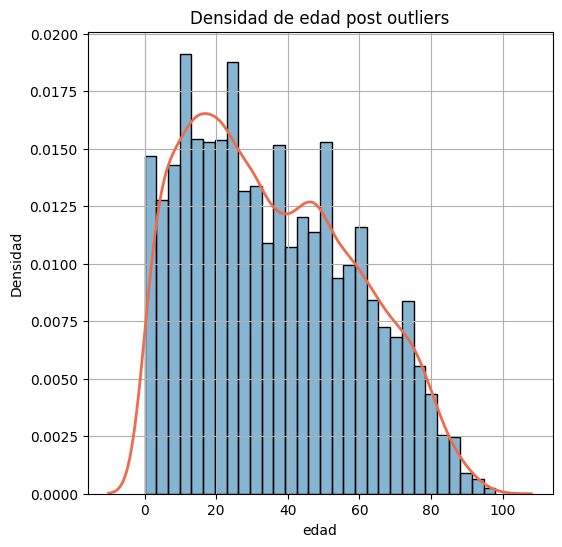

(14614, 317)


In [22]:
# DENSIDAD DE EDAD
plt.figure(figsize=(6, 6))
sns.histplot(base_limpia_dummies['ch06'], bins = 30, color = '#3685B5', kde = False, stat = "density", alpha = 0.6)
sns.kdeplot(base_limpia_dummies['ch06'], color = '#EE6C4D', linewidth = 2)
plt.title('Densidad de edad post outliers')
plt.xlabel('edad')
plt.ylabel('Densidad')
plt.grid()
plt.show()

print(base_limpia_dummies.shape)

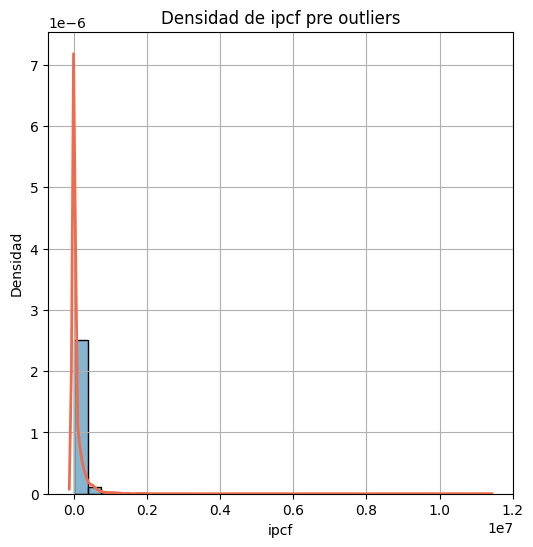

In [23]:
# OUTLIERS DE IPFC

### DENSIDAD DE EDAD --> VER OUTLIERS
plt.figure(figsize=(6, 6))
sns.histplot(base_limpia_dummies['ipcf'], bins = 30, color = '#3685B5', kde = False, stat = "density", alpha = 0.6)
sns.kdeplot(base_limpia_dummies['ipcf'], color = '#EE6C4D', linewidth = 2)
plt.title('Densidad de ipcf pre outliers')
plt.xlabel('ipcf')
plt.ylabel('Densidad')
plt.grid()
plt.show()

In [24]:
# Calcular los cuartiles para la columna 'ch06'
Q1 = base_limpia_dummies['ipcf'].quantile(0.25)  # Primer cuartil
Q3 = base_limpia_dummies['ipcf'].quantile(0.75)  # Tercer cuartil
IQR = Q3 - Q1  # Rango intercuartílico

# Calcular los límites inferior y superior
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

# Mostrar los límites
print(f"Límite inferior: {lower_limit}, Límite superior: {upper_limit}")

# Filtrar el DataFrame para eliminar los outliers
base_limpia_dummies = base_limpia_dummies[(base_limpia_dummies['ipcf'] >= lower_limit) & (base_limpia_dummies['ipcf'] <= upper_limit)]

base_limpia_dummies.shape

Límite inferior: -83183.34, Límite superior: 138798.9


(12172, 317)

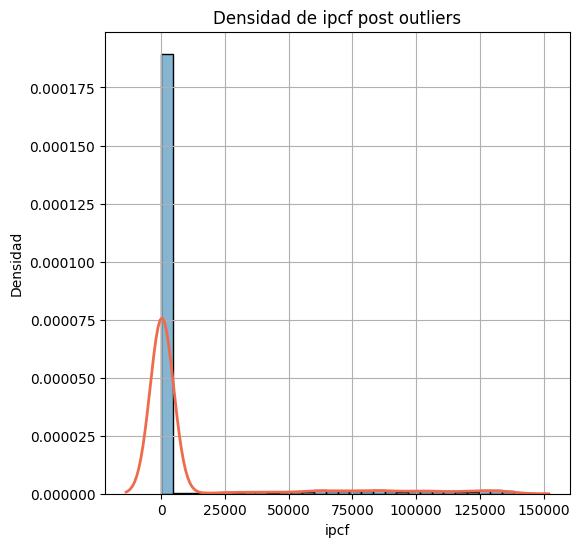

In [25]:
# Visualización de la densidad después de eliminar outliers
plt.figure(figsize=(6, 6))
sns.histplot(base_limpia_dummies['ipcf'], bins=30, color='#3685B5', kde=False, stat="density", alpha=0.6)
sns.kdeplot(base_limpia_dummies['ipcf'], color='#EE6C4D', linewidth=2)
plt.title('Densidad de ipcf post outliers')
plt.xlabel('ipcf')
plt.ylabel('Densidad')
plt.grid()
plt.show()

### PUNTO 4
Construya variables (mínimo 3) que no estén en la base pero que sean relevantes para predecir individuos desocupados (por ejemplo, la proporción de personas que trabajan en el hogar).

In [26]:
# PROPORCION DE PERSONAS QUE TRABAJAN EN UN HOGAR

# Tomo los datos de hogares con trabajadores ocupadas (estado_1)
base_limpia_dummies['trabajadores_hogar'] = base_limpia_dummies['estado_1']

# Calcular la proporción de trabajadores en el hogar
base_limpia_dummies['proporcion_trabajadores'] = base_limpia_dummies['trabajadores_hogar'] / base_limpia_dummies['ix_tot']
base_limpia_dummies[['proporcion_trabajadores']]

,proporcion_trabajadores
0,0.333333
1,0.333333
2,0.333333
4,0.000000
5,0.500000
...,...
14693,0.000000
14694,0.250000
14695,0.250000
14696,0.000000


In [27]:
# PROPORCION DE INGRESOS POR AYUDAS EXTERNAS

# tomo los datos de hogares que reciben ayudas externas y sumo la cantidad de ayudas que reciben
base_limpia_dummies["total_ayudas"] = base_limpia_dummies[["v5_1", "v6_1", "v7_1", "v12_1"]].sum(axis=1)

# Calcular la proporción de ayudas en el hogar
base_limpia_dummies["ingreso_externo"] = base_limpia_dummies['total_ayudas'] / base_limpia_dummies['ix_tot']
base_limpia_dummies[['ingreso_externo']]

,ingreso_externo
0,0.000000
1,0.000000
2,0.000000
4,0.000000
5,0.000000
...,...
14693,0.666667
14694,0.000000
14695,0.000000
14696,0.000000


In [28]:
# PROPORCION DE VENTA DE OBJETOS MATERIALES Y GASTO DE AHORROS EN EL HOGAR

base_limpia_dummies["venta_pertenencias"] = base_limpia_dummies[["v13_1", "v17_1"]].sum(axis = 1)

# Calcular la proporción de ayudas en el hogar
base_limpia_dummies["ingreso_ventas"] = base_limpia_dummies['venta_pertenencias'] / base_limpia_dummies['ix_tot']
base_limpia_dummies[['ingreso_ventas']]

,ingreso_ventas
0,0.000000
1,0.000000
2,0.000000
4,0.000000
5,0.000000
...,...
14693,0.333333
14694,0.000000
14695,0.000000
14696,0.000000


In [29]:
# TRABAJO INFANTIL EN EL HOGAR

base_limpia_dummies["total_infante"] = base_limpia_dummies[["v19_a_1", "v19_b_1"]].sum(axis = 1)

# Calcular la proporción de ayudas en el hogar
base_limpia_dummies["ingreso_infante"] = base_limpia_dummies['total_infante'] / base_limpia_dummies['ix_tot']
base_limpia_dummies[['ingreso_infante']]

#veo si hay observaciones con trabajo infantil: mostrar valores distintos de 0
valores_no_cero = base_limpia_dummies[base_limpia_dummies["ingreso_infante"] != 0]
print(valores_no_cero)

                              codusu    ano4       trimestre  nro_hogar  \
271    TQRMNOSXRHLOSLCDEIJAH00855686  2024.0               1        1.0   
272    TQRMNOSXRHLOSLCDEIJAH00855686  2024.0               1        1.0   
273    TQRMNOSXRHLOSLCDEIJAH00855686  2024.0               1        1.0   
281    TQRMNOSXRHLOSLCDEIJAH00855686  2024.0               1        1.0   
10925                       183926    2004.0  1er. Trimestre        1.0   
10926                       183926    2004.0  1er. Trimestre        1.0   
10927                       183926    2004.0  1er. Trimestre        1.0   
10928                       183926    2004.0  1er. Trimestre        1.0   
10929                       183926    2004.0  1er. Trimestre        1.0   
10930                       183926    2004.0  1er. Trimestre        1.0   
13293                       251422    2004.0  1er. Trimestre        1.0   
13294                       251422    2004.0  1er. Trimestre        1.0   
13295                    

### PUNTO 5
Presenten estadísticas descriptivas de tres variables de la encuesta de hogar que ustedes creen que pueden ser relevantes para predecir la desocupación. Comenten las estadísticas obtenidas.

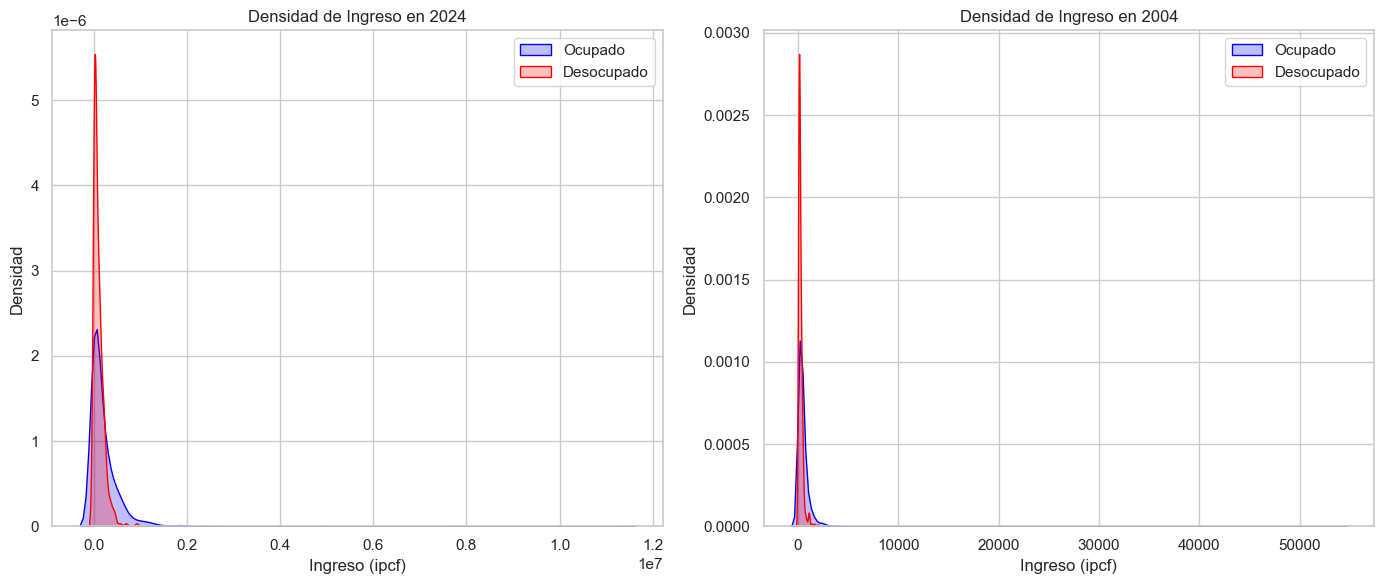

In [73]:
# Filtrar los datos para el año 2024 y 2004
base_2024 = base_limpia[base_limpia['ano4'] == 2024]
base_2004 = base_limpia[base_limpia['ano4'] == 2004]

# Configuración de los gráficos
sns.set(style="whitegrid")

# Crear gráficos de densidad para 2024
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)  # Subgráfico para el año 2024
sns.kdeplot(data=base_2024[base_2024['estado'] == 1], x='ipcf', label='Ocupado', color='blue', fill=True)
sns.kdeplot(data=base_2024[base_2024['estado'] == 2], x='ipcf', label='Desocupado', color='red', fill=True)
plt.title('Densidad de Ingreso en 2024')
plt.xlabel('Ingreso (ipcf)')
plt.ylabel('Densidad')
plt.legend()

# Crear gráficos de densidad para 2004
plt.subplot(1, 2, 2)  # Subgráfico para el año 2004
sns.kdeplot(data=base_2004[base_2004['estado'] == 1], x='ipcf', label='Ocupado', color='blue', fill=True)
sns.kdeplot(data=base_2004[base_2004['estado'] == 2], x='ipcf', label='Desocupado', color='red', fill=True)
plt.title('Densidad de Ingreso en 2004')
plt.xlabel('Ingreso (ipcf)')
plt.ylabel('Densidad')
plt.legend()

# Mostrar los gráficos
plt.tight_layout()
plt.show()


In [68]:
limite = 2_000_000  # Define el límite de 2 millones

# Filtrar datos donde `ipcf` sea menor o igual al límite
df_filtrado = base_limpia[base_limpia['ipcf'] <= limite]


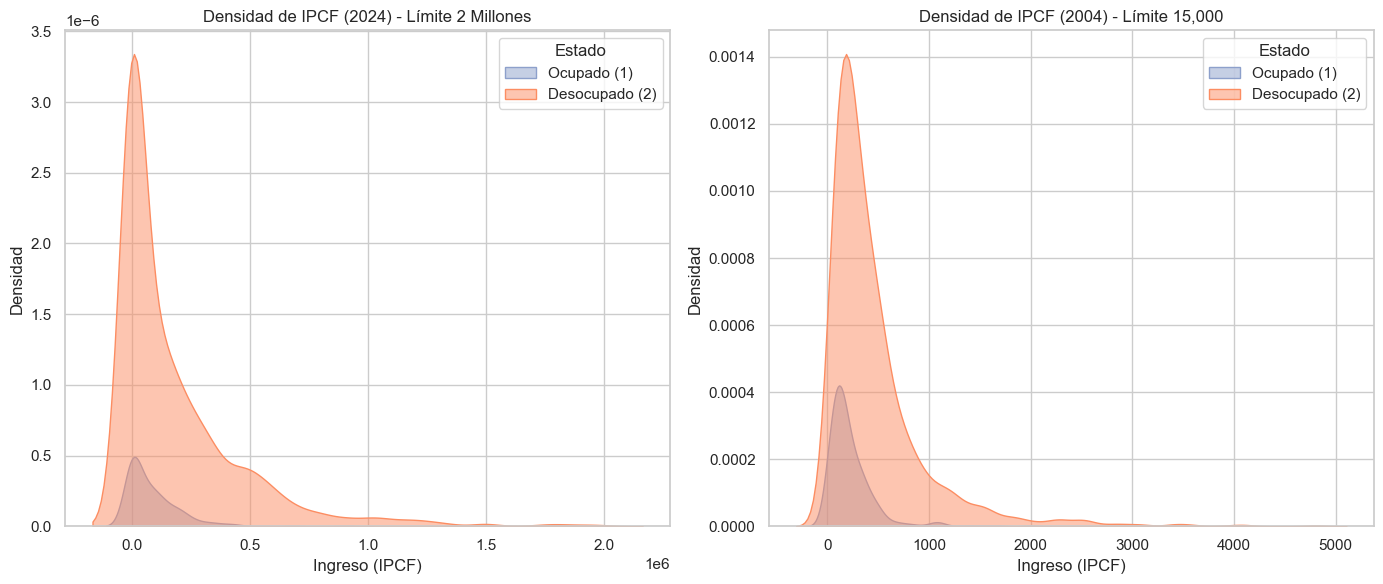

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filtros específicos para cada año y estado
df_2024 = base_limpia[(base_limpia['ano4'] == 2024) & (base_limpia['estado'].isin([1, 2])) & (base_limpia['ipcf'] <= 2_000_000)]
df_2004 = base_limpia[(base_limpia['ano4'] == 2004) & (base_limpia['estado'].isin([1, 2])) & (base_limpia['ipcf'] <= 15_000)]

# Crear gráficos de densidad
plt.figure(figsize=(14, 6))

# Gráfico para 2024
plt.subplot(1, 2, 1)
sns.kdeplot(data=df_2024, x='ipcf', hue='estado', fill=True, alpha=0.5, palette='Set2')
plt.title('Densidad de IPCF (2024) - Límite 2 Millones')
plt.xlabel('Ingreso (IPCF)')
plt.ylabel('Densidad')
plt.legend(title='Estado', labels=['Ocupado (1)', 'Desocupado (2)'])  # Etiquetas personalizadas

# Gráfico para 2004
plt.subplot(1, 2, 2)
sns.kdeplot(data=df_2004, x='ipcf', hue='estado', fill=True, alpha=0.5, palette='Set2')
plt.title('Densidad de IPCF (2004) - Límite 15,000')
plt.xlabel('Ingreso (IPCF)')
plt.ylabel('Densidad')
plt.legend(title='Estado', labels=['Ocupado (1)', 'Desocupado (2)'])  # Etiquetas personalizadas

# Mostrar gráficos
plt.tight_layout()
plt.show()

#que onda las logaritmicas



In [66]:
mediana_ipcf = base_limpia['ipcf'].mean()
print(f"La mediana de ipcf es: {mediana_ipcf}")


La mediana de ipcf es: 77114.42545286508


In [64]:
top_10_ipcf = base_limpia['ipcf'].nlargest(10)
print("Los diez valores más altos de ipcf son:")
print(top_10_ipcf)


Los diez valores más altos de ipcf son:
4989    11312333.33
4990    11312333.33
4991    11312333.33
2689     7750000.00
2690     7750000.00
4805     5875000.00
4806     5875000.00
4852     4910000.00
4853     4910000.00
1431     3000000.00
Name: ipcf, dtype: float64


/var/folders/9r/73xgxgj17t7btpfss2pdczcr0000gn/T/ipykernel_39521/3091781570.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_limpia['v5'] = base_limpia['v5']


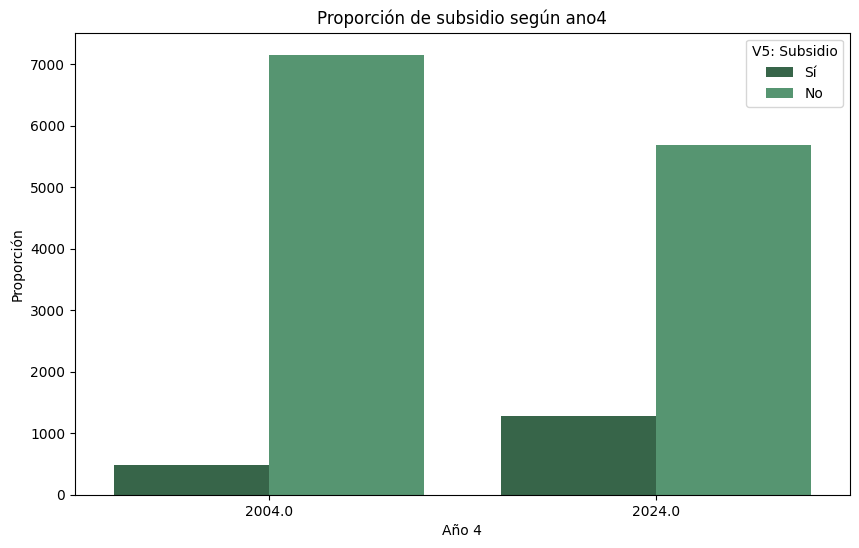

In [30]:
#No terminode entender que representaria esos numeros de proporcion 

# Reemplazar las etiquetas 'sí' y 'no' en la variable 'v5'
base_limpia['v5'] = base_limpia['v5']

# Crear el gráfico de barras con una paleta personalizada de verdes más oscuros
plt.figure(figsize=(10, 6))
sns.countplot(data=base_limpia, x='ano4', hue='v5',  palette=["#2F6D47", "#4C9F70"])

# Etiquetas y título
plt.title('Proporción de subsidio según ano4')
plt.xlabel('Año 4')
plt.ylabel('Proporción')
plt.legend(title='V5: Subsidio', loc='upper right', labels=['Sí', 'No'])

# Mostrar el gráfico
plt.show()

/var/folders/9r/73xgxgj17t7btpfss2pdczcr0000gn/T/ipykernel_39521/1655528450.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_limpia['v6'] = base_limpia['v6']
/var/folders/9r/73xgxgj17t7btpfss2pdczcr0000gn/T/ipykernel_39521/1655528450.py:7: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(data=base_limpia, x='ano4', hue='v6', palette=["#2F6D47", "#4C9F70"])


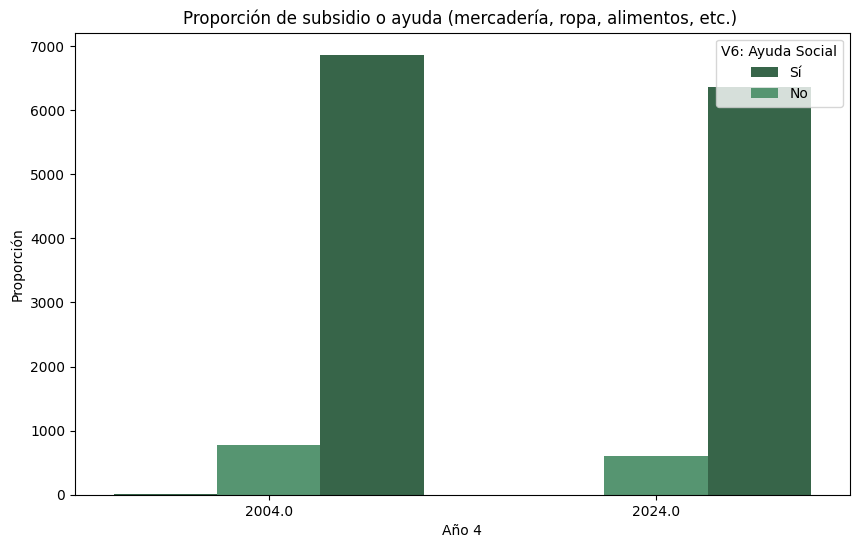

In [31]:
# V6 (si en los últimos 3 meses vivieron con mercaderia, ropa, alimentos del gobierno, iglesias, etc)
# Reemplazar las etiquetas 'sí' y 'no' en la variable 'v6'
base_limpia['v6'] = base_limpia['v6']

# Crear el gráfico de barras con tonalidades de verde
plt.figure(figsize=(10, 6))
sns.countplot(data=base_limpia, x='ano4', hue='v6', palette=["#2F6D47", "#4C9F70"])



# Etiquetas y título
plt.title('Proporción de subsidio o ayuda (mercadería, ropa, alimentos, etc.) ')
plt.xlabel('Año 4')
plt.ylabel('Proporción')
plt.legend(title='V6: Ayuda Social', loc='upper right', labels=['Sí', 'No'])

# Mostrar el gráfico
plt.show()

In [32]:
# V7 (si en los últimos 3 meses vivieron con mercaderia, ropa, alimentos de personas externas al hogar)


/var/folders/9r/73xgxgj17t7btpfss2pdczcr0000gn/T/ipykernel_39521/3204467956.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_limpia['v13'] = base_limpia['v13']


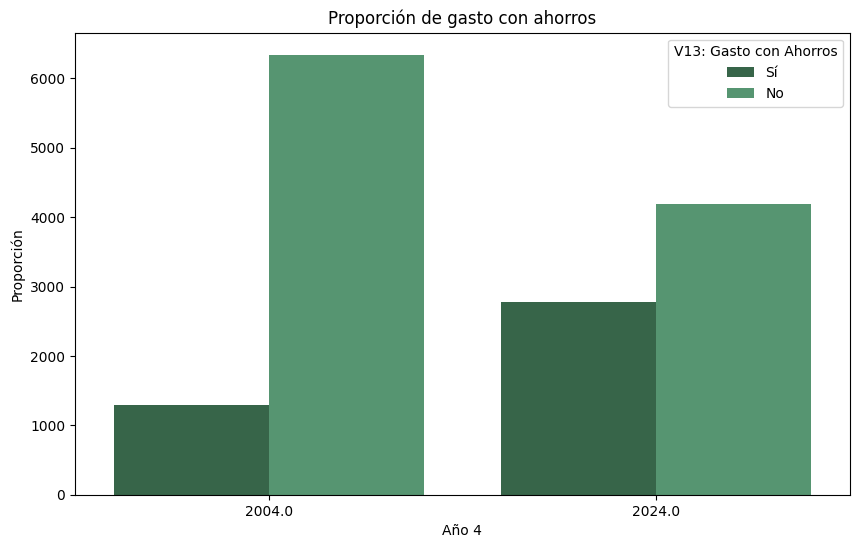

In [33]:
# V13 (si en los ultimos 3 meses vivieron gastando lo que tenian ahorrado)

# Reemplazar las etiquetas 'sí' y 'no' en la variable 'v13'
base_limpia['v13'] = base_limpia['v13']

# Crear el gráfico de barras con tonalidades de verde
plt.figure(figsize=(10, 6))
sns.countplot(data=base_limpia, x='ano4', hue='v13', palette=["#2F6D47", "#4C9F70"])

# Etiquetas y título
plt.title('Proporción de gasto con ahorros')
plt.xlabel('Año 4')
plt.ylabel('Proporción')
plt.legend(title='V13: Gasto con Ahorros', loc='upper right', labels=['Sí', 'No'])

# Mostrar el gráfico
plt.show()


## Parte II: Clasificación y regularización
El objetivo de esta parte del trabajo es nuevamente intentar predecir si una persona está desocupada o no. Esta vez utilizando distintas variables de características individuales y del hogar del encuestado. A su vez, incluiremos ejercicios de regularización y de validación cruzada.

In [77]:
# Base con datos que sí respondieron a la condición de actividad
respondieron = base_limpia_dummies[base_limpia_dummies['estado_0'] == 0]
respondieron_cant = respondieron.shape[0]

print("La cantidad de personas que respondieron a la pregunta de condición de actividad son:", respondieron_cant)

# Base con datos que no respondieron a la condición de actividad
no_respondieron = base_limpia_dummies[base_limpia_dummies['estado_0'] == 1]
no_respondieron_cant = no_respondieron.shape[0]

print("La cantidad de personas que no respondieron a la pregunta de condición de actividad son:", no_respondieron_cant)


La cantidad de personas que respondieron a la pregunta de condición de actividad son: 14573
La cantidad de personas que no respondieron a la pregunta de condición de actividad son: 34


### PUNTO 1
Para cada año, partan la base respondieron en una base de prueba y una de entrenamiento (X_train, y_train, X_test, y_test) utilizando el comando train_test_split. La base de entrenamiento debe comprender el 70% de los datos, y la semilla a utilizar (random state instance) debe ser 101. Establezca a desocupado como su variable dependiente en la base de entrenamiento (vector y). El resto de las variables serán las variables independientes (matriz X). Recuerden agregar la columna de unos (1).


In [82]:
# Separar las bases por años
from sklearn.model_selection import train_test_split

# Para 2004
train_2004, test_2004 = train_test_split(respondieron[respondieron['ano4'] == 2004], test_size=0.3, random_state=101)
# separar en entrenamiento y test por cada año
X_train_2004 = train_2004.drop(columns=['estado_2', 'ano4','codusu'])  # Eliminamos la variable dependiente y año porque ya dividimos las bases de un principio
y_train_2004 = (train_2004['estado_2']).astype(int)  # Convertimos a 1 si es desocupado, 0 si no
#agrego columna de unos
X_train_2004 = X_train_2004.assign(intercept=1)

# Para 2024
train_2024, test_2024 = train_test_split(respondieron[respondieron['ano4'] == 2024], test_size=0.3, random_state=101)
X_train_2024 = train_2024.drop(columns=['estado_2', 'ano4','codusu'])  # Eliminamos la variable dependiente y año porque ya dividimos las bases de un principio
y_train_2024 = (train_2024['estado_2']).astype(int)  # Convertimos a 1 si es desocupado, 0 si no
#agrego columna de unos
X_train_2024 = X_train_2024.assign(intercept=1)

print(X_train_2004.shape)
print(y_train_2004.shape)
print(X_train_2024.shape)
print(y_train_2024.shape)


(5338, 304)
(5338,)
(4862, 304)
(4862,)


### PUNTO 2
Expliquen brevemente cómo elegirían λ por validación cruzada (en Python es alpha). Detallen por qué no usarían el conjunto de prueba(test) para su elección.

### PUNTO 3
En validación cruzada, ¿cuáles son las implicancias de usar un k muy pequeño o uno muy grande? Cuando k = n (con n el número de muestras), ¿cuántas veces se estima el modelo?

### PUNTO 4
Para regresión logística, implementen la penalidad, L1 como la de LASSO y L2 comola de Ridge con (como en la Tutorial 10), usando λ = 1 la opción penalty y reporten la matriz de confusión, la curva ROC, los valores de AUC y de Accuracy para cada año (En la clase magistral 9, vimos el método de regularización en regresión lineal donde la variable dependiente es numérica. En este caso, nuestra variable dependiente es binaria (ocupado, desocupado), por lo que usamos la regresión logística y aprovechamos la opción de penalidad para aplicar los métodos de regularización vistos en clase.) ¿Cómo cambiaron los resultados con respecto al TP3? ¿La performance de regresión logística con regularización es mejor o peor?

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt

def entrenar_evaluar_logistica(X_train, y_train, X_test, y_test, penalty):
    """
    Entrena un modelo de regresión logística con penalización L1 o L2 y evalúa su desempeño.
    
    Args:
        X_train: Matriz de características para entrenamiento.
        y_train: Vector de etiquetas para entrenamiento.
        X_test: Matriz de características para prueba.
        y_test: Vector de etiquetas para prueba.
        penalty: Tipo de penalización ('l1' o 'l2').

    Returns:
        result: Diccionario con métricas de evaluación (matriz de confusión, AUC, Accuracy).
    """
    # Entrenar el modelo
    modelo = LogisticRegression(penalty=penalty, C=1, solver='saga', max_iter=1000)
    modelo.fit(X_train, y_train)
    
    # Predicciones
    y_pred = modelo.predict(X_test)
    y_prob = modelo.predict_proba(X_test)[:, 1]
    
    # Calcular métricas
    matriz_confusion = confusion_matrix(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_score = auc(fpr, tpr)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Graficar la curva ROC
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc_score:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"Curva ROC - Penalización {penalty.upper()}")
    plt.legend()
    plt.show()
    
    return {
        'Matriz de Confusión': matriz_confusion,
        'AUC': auc_score,
        'Accuracy': accuracy
    }

# Evaluar para 2004 y 2024 con penalización L1 y L2
resultados_2004_L1 = entrenar_evaluar_logistica(X_train_2004, y_train_2004, X_test_2004, y_test_2004, penalty='l1')
resultados_2004_L2 = entrenar_evaluar_logistica(X_train_2004, y_train_2004, X_test_2004, y_test_2004, penalty='l2')
resultados_2024_L1 = entrenar_evaluar_logistica(X_train_2024, y_train_2024, X_test_2024, y_test_2024, penalty='l1')
resultados_2024_L2 = entrenar_evaluar_logistica(X_train_2024, y_train_2024, X_test_2024, y_test_2024, penalty='l2')

# Imprimir resultados
print("Resultados para 2004 con penalización L1:", resultados_2004_L1)
print("Resultados para 2004 con penalización L2:", resultados_2004_L2)
print("Resultados para 2024 con penalización L1:", resultados_2024_L1)
print("Resultados para 2024 con penalización L2:", resultados_2024_L2)

ValueError: Cannot cast object dtype to float64

### PUNTO 5
Realicen un barrido en = 10n con n ∈ {−5, −4, −3 ..., +4, +5} y utilicen 10-fold CV para elegir el óptimo en regresión logística con Ridge y con λ LASSO. ¿Qué seleccionó en cada caso? Usando la librería de seaborn, generen box plot mostrando la distribución del error de predicción para cada . Cada box debe corresponder a un valor de y contener como λ observaciones el error medio de validación (MSE) para cada partición. Además, para la regularización LASSO, generen un line plot del promedio de la proporción de variables ignoradas por el modelo en función de (como vieron en el tutorial 10), es decir la proporción de λ variables para las cuales el coeficiente asociado es cero (Hint: a mayor penalidad, esperamos que más coeficientes sean 0, por lo tanto, esta figura debe tener una forma de “S”)

### PUNTO 6
En el caso del valor óptimo de para LASSO encontrado en el inciso λ anterior, ¿qué variables fueron descartadas? ¿Son las que hubieran esperado? ¿Tiene relación con lo que respondieron en el inciso 1 de la Parte I?

### PUNTO 7
Elijan alguno de los modelos de regresión logística donde hayan probado distintos parámetros de regularización y comenten: Compare los resultados de 2004 versus 2024, ¿qué método de regularización funcionó mejor: Ridge o LASSO? ¿LASSO hizo una selección distinta de predictores en 2004 versus 2024? Comenten mencionando el error cuadrático medio (MSE)